# VGG16 Transfer Learning Example Using Fruit Data

This is an example showing how an existing, fully trained CNN, can be used for a different classification task. This is achieved removing the existing fully connected layer, the head, from the model, and replacing it with a new one. All the existing weights of the CNN are kept, while the new fully connected layer is trained. VGG16 from tensorflow is used as the base network, and the training is done using the Fruits 360 data from https://www.kaggle.com/moltean/fruits.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
import gdown
import zipfile
import utils

tensorflow version: 2.6.0


In [2]:
def download_fruit_data():
    url = 'https://drive.google.com/file/d/1_Yi9Q3BqsrogWHQ0TLEq-6GcsjnJjW4o/view?usp=sharing'
    output = './large_files/fruits-360.zip'
    if not os.path.exists('./large_files/fruits-360'):
        gdown.download(url, output, quiet=False, fuzzy=True)
        with zipfile.ZipFile('./large_files/fruits-360.zip', 'r') as zip_ref:
            zip_ref.extractall('./large_files')

def mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst, target_is_directory=True)

In [3]:
# Download the fruit data
download_fruit_data()

Downloading...
From: https://drive.google.com/uc?id=1_Yi9Q3BqsrogWHQ0TLEq-6GcsjnJjW4o
To: /home/jarno/projects/deep-learning-examples/large_files/fruits-360.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800M/800M [00:32<00:00, 24.6MB/s]


In [4]:
# We don't use all of the available classes for training and testing.
# We choose only those defined in the variable 'classes'. The class names
# correspond to directory names that contain images of the class in question.
# The data is expected to be in the following directory
# ./large_files/fruits-360
# We create a new directory called ./large_files/fruits-360-8-classes
# and create symbolic links to the directories in ./large_files/fruits-360, as
# defined by the variable 'classes'.

src_path_training = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360', 'Training')
src_path_test = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360', 'Test')

dst_path = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360-8-classes')
dst_path_training = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360-8-classes', 'Training')
dst_path_test = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360-8-classes', 'Test')

mkdir(dst_path_training)
mkdir(dst_path_test)

classes = [
    'Apple Golden 1',
    'Avocado',
    'Lemon',
    'Mango',
    'Kiwi',
    'Banana',
    'Strawberry',
    'Raspberry'
]

# Generate the symbolic links
for fruit_class in classes:
    # Symbolic links to the training data
    if os.path.exists(os.path.join(src_path_training, fruit_class)):
        print(f'{os.path.join(src_path_training, fruit_class)} -> {os.path.join(dst_path_training, fruit_class)}')
        link(os.path.join(src_path_training, fruit_class), os.path.join(dst_path_training, fruit_class))
    else:
        raise RuntimeError(f'Directory "{os.path.join(src_path_training, fruit_class)}" does not exist')

    # Symbolic links to the test data
    if os.path.exists(os.path.join(src_path_test, fruit_class)):
        print(f'{os.path.join(src_path_test, fruit_class)} -> {os.path.join(dst_path_test, fruit_class)}')
        link(os.path.join(src_path_test, fruit_class), os.path.join(dst_path_test, fruit_class))
    else:
        raise RuntimeError(f'Directory "{os.path.join(src_path_test, fruit_class)}" does not exist')

/home/jarno/projects/deep-learning-examples/large_files/fruits-360/Training/Apple Golden 1 -> /home/jarno/projects/deep-learning-examples/large_files/fruits-360-8-classes/Training/Apple Golden 1
/home/jarno/projects/deep-learning-examples/large_files/fruits-360/Test/Apple Golden 1 -> /home/jarno/projects/deep-learning-examples/large_files/fruits-360-8-classes/Test/Apple Golden 1
/home/jarno/projects/deep-learning-examples/large_files/fruits-360/Training/Avocado -> /home/jarno/projects/deep-learning-examples/large_files/fruits-360-8-classes/Training/Avocado
/home/jarno/projects/deep-learning-examples/large_files/fruits-360/Test/Avocado -> /home/jarno/projects/deep-learning-examples/large_files/fruits-360-8-classes/Test/Avocado
/home/jarno/projects/deep-learning-examples/large_files/fruits-360/Training/Lemon -> /home/jarno/projects/deep-learning-examples/large_files/fruits-360-8-classes/Training/Lemon
/home/jarno/projects/deep-learning-examples/large_files/fruits-360/Test/Lemon -> /home/

In [5]:
image_size = [100, 100]

training_images = glob(dst_path_training + '/*/*.jp*g')
test_images = glob(dst_path_test + '/*/*.jp*g')
folders = glob(dst_path_training + '/*')

print(f'Number of training images: {len(training_images)}')
print(f'Number of testing images: {len(test_images)}')
print(f'Number of classes: {len(folders)}')

Number of training images: 3827
Number of testing images: 1285
Number of classes: 8


In [6]:
# Here we create a model that uses vgg16's CNN layers, with given weights, and
# add a classification head to the model. Only the classifier weights are trained.

# Convolutional layers are from vgg16
vgg = VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)

# Don't train existing vgg16 weights
for layer in vgg.layers:
    layer.trainable = False

# Output prediction layer
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# Create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# Display summary of the model
model.summary()

# Add loss and optimization methods
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Image augmentation using ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Found 3827 images belonging to 8 classes.
Image classes
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}
Displaing an image from the generator


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image type: <class 'numpy.ndarray'>
Image max value: 151.06100463867188
Image min value: -123.33072662353516


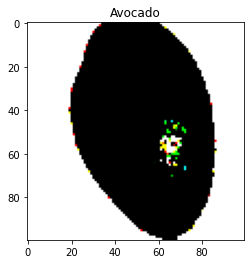

In [7]:
# Image augmentation generator
test_gen = gen.flow_from_directory(dst_path_training, target_size=image_size)
print('Image classes')
print(test_gen.class_indices)

# Extract labels. These are based on the directory names for each class
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# We expect the image to look 'strange' due to using the preprocessor of the VGG16
print('Displaing an image from the generator')
for x, y in test_gen:
    plt.title(labels[np.argmax(y[0])])
    print(f'Image type: {type(x[0])}')
    print(f'Image max value: {np.max(x[0])}')
    print(f'Image min value: {np.min(x[0])}')
    plt.imshow(x[0])
    plt.show()
    break

In [8]:
epochs = 5
batch_size = 32

print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

# Training image augmentation generator
training_generator = gen.flow_from_directory(
    dst_path_training,
    target_size=image_size,
    shuffle=True,
    batch_size=batch_size
)

# Validation image augmentation generator
validation_generator = gen.flow_from_directory(
    dst_path_test,
    target_size=image_size,
    shuffle=True,
    batch_size=batch_size
)

# Fit the model
r = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=len(training_images) // batch_size,
    validation_steps=len(test_images) // batch_size
)

Epochs: 5
Batch size: 32
Found 3827 images belonging to 8 classes.
Found 1285 images belonging to 8 classes.
Epoch 1/5
119/119 [==============================] - 16s 108ms/step - loss: 0.8443 - accuracy: 0.9378 - val_loss: 0.0179 - val_accuracy: 0.9961
Epoch 2/5
119/119 [==============================] - 12s 103ms/step - loss: 0.0180 - accuracy: 0.9979 - val_loss: 0.0442 - val_accuracy: 0.9906
Epoch 3/5
119/119 [==============================] - 12s 101ms/step - loss: 0.0145 - accuracy: 0.9966 - val_loss: 0.0180 - val_accuracy: 0.9969
Epoch 4/5
119/119 [==============================] - 12s 101ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0521 - val_accuracy: 0.9914
Epoch 5/5
119/119 [==============================] - 12s 101ms/step - loss: 0.0283 - accuracy: 0.9953 - val_loss: 0.0163 - val_accuracy: 0.9969


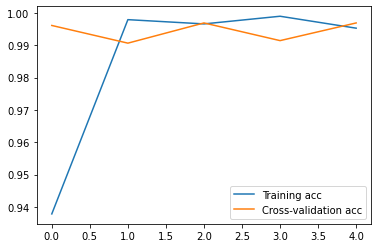

In [9]:
# Plot training- and cross-validation accuracy
plt.plot(r.history['accuracy'], label='Training acc')
plt.plot(r.history['val_accuracy'], label='Cross-validation acc')
plt.legend()

Creating a confusion matrix
Found 3827 images belonging to 8 classes.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 119/120 [00:15<00:00,  7.82it/s]


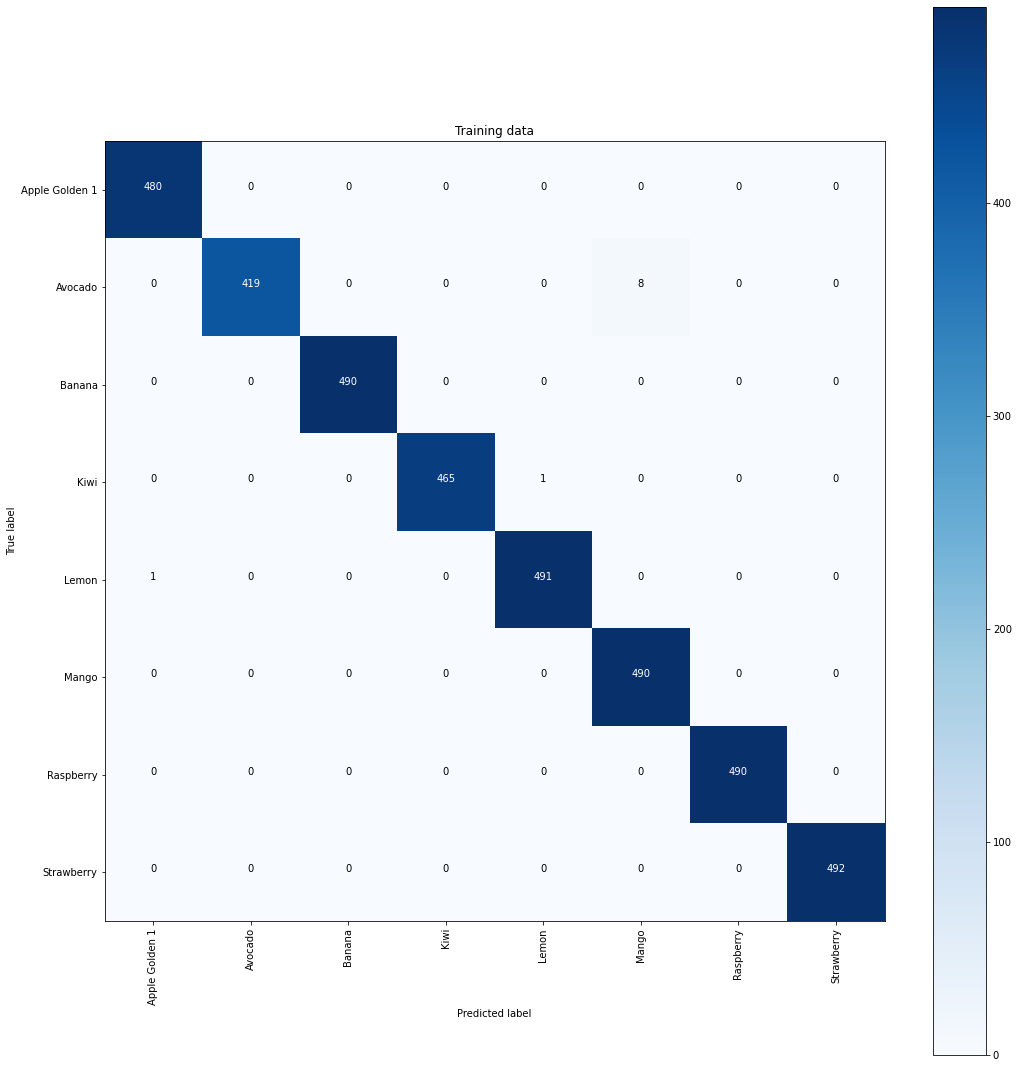

In [10]:
# Create and display confusion matrix for the training data
cm, class_names_training = utils.get_confusion_matrix(model, gen, dst_path_training, image_size)
utils.plot_confusion_matrix(cm, class_names_training, 'Training data')

Creating a confusion matrix
Found 1285 images belonging to 8 classes.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 40/41 [00:05<00:00,  7.54it/s]


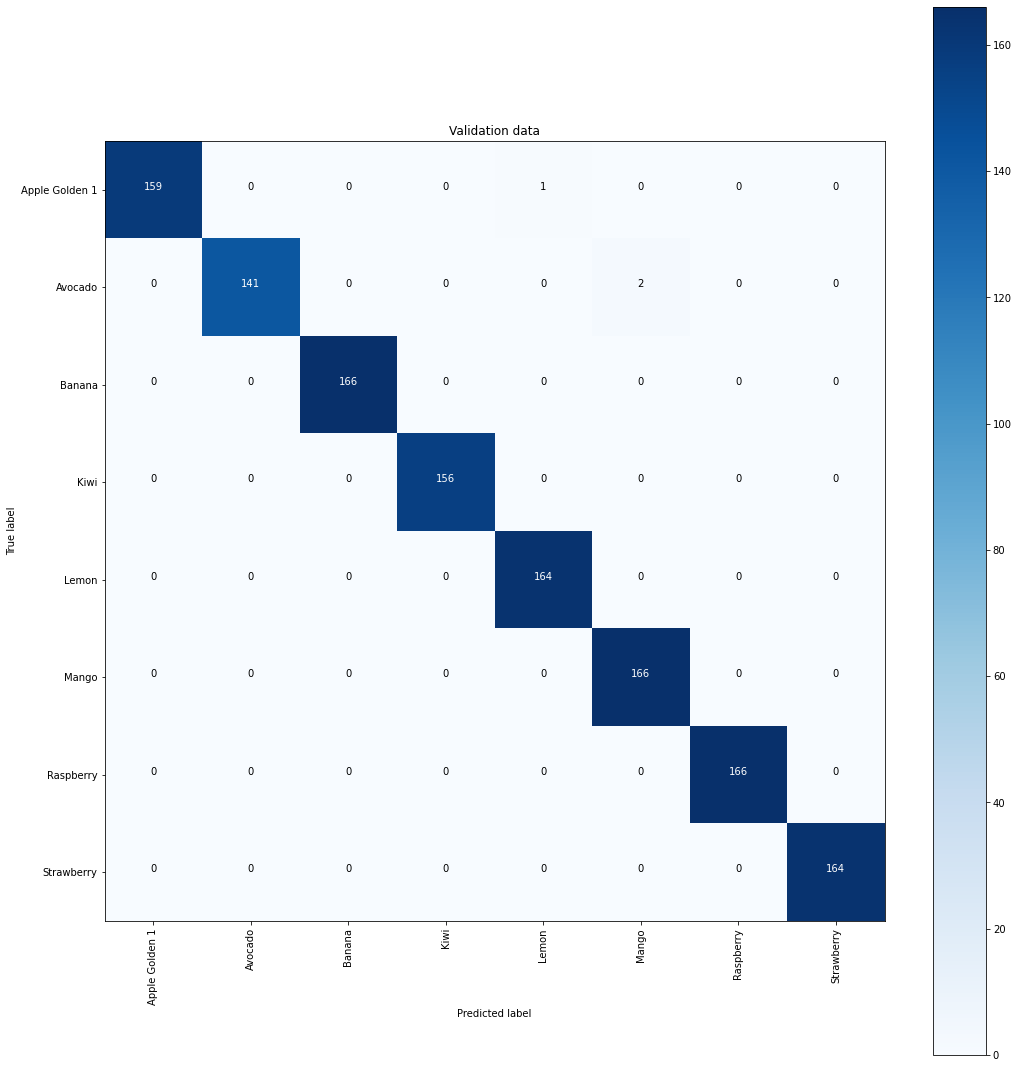

In [11]:
# Create and display confusion matrix for the validation data
validation_cm, class_names_validation = utils.get_confusion_matrix(model, gen, dst_path_test, image_size)
utils.plot_confusion_matrix(validation_cm, class_names_validation, 'Validation data')